# Exercise 1
Let's build the graph described in the exercise

In [8]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline


G = nx.DiGraph()
G.add_edges_from([('a','d'),('b','d'),('c','d'),('b','c'),('o','b'),('o','a')])
pos = {'o': [0,1], 'a': [1,2], 'b': [1,1], 'c': [1,0], 'd': [2,1]}

G['o']['a']['capacity'] = 2
G['a']['d']['capacity'] = 1
G['o']['b']['capacity'] = 2
G['b']['d']['capacity'] = 1
G['b']['c']['capacity'] = 2
G['c']['d']['capacity'] = 1

nx.draw_networkx_edge_labels(G,pos, font_color='red')
nx.draw(G, pos, with_labels = True)

### Esercise 1.A

To find the mimimum aggregate capacity that must be removed it's enough to calculate the minimum cut. 
The value obtained is the minimum capacity that must be removed.

In [259]:
cut_value, partition = nx.minimum_cut(G, "o", "d")
cut_value, partition

(3, ({'a', 'b', 'c', 'o'}, {'d'}))

### Exercise 1.B

In [260]:
#this is function can be used to visualize some information about the current network and it's used later on
#in the exercises
def info(G):
    value, sets_edges = nx.minimum_cut(G, "o", "d")
    print("Values of min-cut:", value, ". Sets of vertexes obtained: ",  sets_edges)
    for e in list(nx.edges(G)):
        print(e, "  ",G[e[0]][e[1]])

#maxCap function is used to obtain the max capacity of a edge in the whole graph
def maxCap(G):
    maxCapacity = 0
    for e in list(G.edges):
        if maxCapacity < G[e[0]][e[1]]['capacity']:
            maxCapacity = G[e[0]][e[1]]['capacity']
    return maxCapacity

#in order to not change the initial graph we define a new one
G1 = nx.DiGraph(G)

#defining some vaiable usefeul for the following loop
#(mainly memory variables and list to be filled)
maxCap = maxCap(G)
aggr_capacity = 0
oldMaxFlow = nx.minimum_cut_value(G, "o", "d")
edges = list(G.edges)
ListOfEdgesDecreased = []

#MAIN PRINCIPLE: try to remove a capacity unit one edge at a time 
#(up to a maximum of maxCap) for every edge and check if the min cut decreases
for cap in range(1,maxCap +1):
    #iterate over every edge
    for e in edges:
        #for every edge decrease by one the capacity 
        G1[e[0]][e[1]]['capacity'] = G1[e[0]][e[1]]['capacity'] - 1
        #compute the maxFlow: if it is the same as the old one
        #we increase the aggregate capacity by one.
        #if the maxFlow < oldMaxFlow we just then the algorithm is decreasing the maxflow by reducing the capacity
        #of the edge and therefore we go back to the original capacity of the edge by adding one.
        #Also in the case of having a negative capacity it is added a one
        #because negative capacity doesn't make sense in this context
        maxFlow = nx.minimum_cut_value(G1, "o", "d")
        if maxFlow != oldMaxFlow or G1[e[0]][e[1]]['capacity'] < 0:
            G1[e[0]][e[1]]['capacity'] = G1[e[0]][e[1]]['capacity'] + 1
        else:
            ListOfEdgesDecreased.append(e[0] +"-"+ e[1])
            aggr_capacity += 1

#print the total aggregate capacity 
print('aggr_capacity that can be removed', aggr_capacity)
print('list of edges from which the capacity is removed', ListOfEdgesDecreased)

aggr_capacity that can be removed 2
list of edges from which the capacity is removed ['b-c', 'o-a']


### Exercise 1.C

In [261]:
#we proceed defining some useful functions

#function returning the common elements in two list
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

#given two vertexes this function checks if one of the fisrt on
#belongs to any any edge going directed towards v1.
#If that is the case then the edge taken in consideration
#cannot be an edge of the min cut.
#Infact, both vertexes belongs to a list of vertexes (final_elements) whose edges 
#between them are not cut by the minimum cut
def check_in_edges(v2, v1, G):
    for e in G.in_edges(v1):
        if v2 in e:
            no_cut_edge = e
            return no_cut_edge
    
def findEdgesMinCut(G):
    oldMinCutV, sets =  nx.minimum_cut(G, "o", "d")
    #final_elements is the subset of vertexes near "d" vertex
    #found by the minimumcut
    final_elements = sets[1]
    no_cut_edges = []
    all_edges = []
    
    #find edges that do not belong to the min cut
    for v1 in final_elements:
        for v2 in final_elements:
            if v1 != v2:
                no_cut_edges.append(check_in_edges(v2, v1, G))
    
    #get all edges that have as final vertex a final_elements vertex
    for v1 in final_elements:
        for e in G.in_edges(v1):
            all_edges.append(e)
    
    #subtract all edges with the ones not cut by the minimum cut
    #to have all edges cut by the minimum cut
    for e in no_cut_edges:
        if e is not None:
            all_edges.remove(e)
    
    minimum_cut_edge = all_edges
    return minimum_cut_edge

#get the edges belonging to the shortest path
def shortest_paths_edges(G):
    shortest_paths = [p for p in nx.all_shortest_paths(G, source='o', target='d')]
    list = []
    for shortest_path_vertexes in shortest_paths:
        for vertex_pos in range(len(shortest_path_vertexes) - 1):
            edge = (shortest_path_vertexes[vertex_pos], shortest_path_vertexes[vertex_pos + 1])
            list.append(edge)
    return list

In [262]:
nx.draw_networkx_edge_labels(G,pos, font_color='red')
nx.draw(G, pos, with_labels = True)
info(G)

#final function requested by exercise 3.c
def adding_Capacity_Optimizer(G, x):
    oldMinCutV = nx.minimum_cut_value(G, "o", "d")
    #iterate for n = capacity units to be assigned
    for i in range(1, x + 1):
        print('\nAdding x =', i,' capacity')
        #find the edges in common between the cut edges of the current minimum cut
        #and the edges belonging to the shortest path 
        intersection_edges = intersection(findEdgesMinCut(G), shortest_paths_edges(G))
        
        #iterate over the intersection of those edges adding the capacity only if the maximum capacity increases
        #(oldMinCutV < newMinCutV) or when there is no other edge to add the capacity to in the intersection_edges.
        #That is the last one
        for i, e in enumerate(intersection_edges):
            G[e[0]][e[1]]['capacity'] = G[e[0]][e[1]]['capacity'] + 1
            newMinCutV = nx.minimum_cut_value(G1, "o", "d")
            #info(G1)
            if oldMinCutV < newMinCutV or i == len(intersection_edges)-1:
                oldMinCutV = newMinCutV
                print('Capacity added to edge:',e[0],'-',e[1])
                break
            else:
                G[e[0]][e[1]]['capacity'] = G[e[0]][e[1]]['capacity'] - 1
    
    #return the maximum throughput
    return oldMinCutV

#create arrays to plot the results
y = []
for x in range(1, 15):
    G1 = nx.DiGraph(G)
    y.append(adding_Capacity_Optimizer(G1, x))
x = [*range(1, 15)]
print(x, '\n', y)

Values of min-cut: 3 . Sets of vertexes obtained:  ({'b', 'a', 'o', 'c'}, {'d'})
('a', 'd')    {'capacity': 1}
('b', 'd')    {'capacity': 1}
('b', 'c')    {'capacity': 2}
('c', 'd')    {'capacity': 1}
('o', 'b')    {'capacity': 2}
('o', 'a')    {'capacity': 2}

Adding x = 1  capacity
Capacity added to edge: a - d

Adding x = 1  capacity
Capacity added to edge: a - d

Adding x = 2  capacity
Capacity added to edge: b - d

Adding x = 1  capacity
Capacity added to edge: a - d

Adding x = 2  capacity
Capacity added to edge: b - d

Adding x = 3  capacity
Capacity added to edge: o - b

Adding x = 1  capacity
Capacity added to edge: a - d

Adding x = 2  capacity
Capacity added to edge: b - d

Adding x = 3  capacity
Capacity added to edge: o - b

Adding x = 4  capacity
Capacity added to edge: b - d

Adding x = 1  capacity
Capacity added to edge: a - d

Adding x = 2  capacity
Capacity added to edge: b - d

Adding x = 3  capacity
Capacity added to edge: o - b

Adding x = 4  capacity
Capacity adde

In [263]:
import matplotlib.pyplot as plt
plt.plot(x, y)

plt.xlabel('Capacity Added (x)')
plt.ylabel('Max Flow')

plt.show()


# Exercise 2

### Exercise 2.a

perfect matching exist !
(4, {'p1': {'b1': 0, 'b2': 1, 'o': 0}, 'b1': {'p1': 0, 'p3': 0, 'p4': 0, 'd': 1}, 'b2': {'p1': 0, 'p2': 0, 'p4': 0, 'd': 1}, 'p2': {'b2': 0, 'b3': 1, 'o': 0}, 'b3': {'p2': 0, 'd': 1}, 'p3': {'b4': 1, 'b1': 0, 'o': 0}, 'b4': {'p3': 0, 'p4': 0, 'd': 1}, 'p4': {'b1': 1, 'b2': 0, 'b4': 0, 'o': 0}, 'o': {'p1': 1, 'p2': 1, 'p3': 1, 'p4': 1}, 'd': {'b1': 0, 'b2': 0, 'b3': 0, 'b4': 0}})


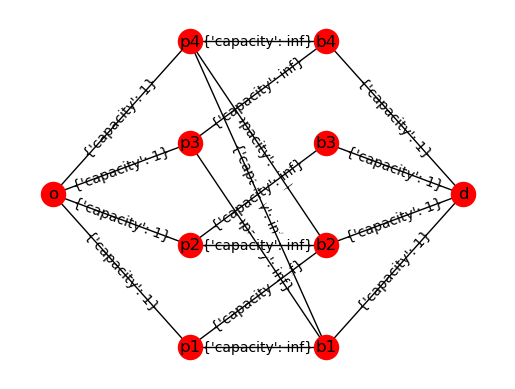

In [264]:
import math

G = nx.Graph()
original_edges = [('p1','b1'), ('p1','b2'), ('p2','b2'), ('p2','b3'), ('p3','b4'),\
                  ('p3','b1'), ('p4','b1'), ('p4','b2'), ('p4','b4')]
added_edges = [('o', 'p1'), ('o', 'p2'), ('o', 'p3'), ('o', 'p4'),
                  ('d', 'b1'), ('d', 'b2'), ('d', 'b3'), ('d', 'b4')]

G.add_edges_from(original_edges)
G.add_edges_from(added_edges)

pos = {'o':[-2, 3], 'p1':[0,0], 'p2':[0,2], 'p3':[0,4], 'p4':[0,6], 'b1':[2,0], 'b2':[2,2], 'b3':[2,4], 'b4':[2,6], 'd':[4,3] }


#assigning infinite capacity to the original edges of the graph
for e in original_edges:
    G[e[0]][e[1]]['capacity'] = math.inf
    
#assigning one capacity to the original edges of the graph
for e in added_edges:
    G[e[0]][e[1]]['capacity'] = 1

numberOfPeople = []
#iterate over the original_edges in order to get the all vertixes representing a person
for e in original_edges:
    if e[0][0] == 'p':
        numberOfPeople.append(e[0])
    
    if e[1][0] == 'p':
        numberOfPeople.append(e[1])
        
numberOfBooks= []
#iterate over the original_edges in order to get the all vertixes representing a bpok
for e in original_edges:
    if e[0][0] == 'b':
        numberOfBooks.append(e[0])
    
    if e[1][0] == 'b':
        numberOfBooks.append(e[1])    

#making sure no person or book appears more then one time
numberOfPeople = list(set(numberOfPeople))
numberOfBooks = list(set(numberOfBooks))


#number of people =  minimum cut? if yes perfect matching exist
if nx.minimum_cut_value(G, "o", "d") == len(numberOfPeople) and len(numberOfPeople) == len(numberOfBooks):
    print('perfect matching exist !')

res = nx.maximum_flow(G, "o", "d")
print(res)
    
nx.draw_networkx_edge_labels(G,pos, )
nx.draw(G, pos, with_labels = True, node_color = "red")
    

### Exercise 2.b

Let’s change the capacity of the final edges in
order to mimic the new number of books available.
To model multiple copies of a book, a new capacity
of edge (bi, d) equal to the number of copies of
bi is added. Additionally another capacity of edge
(o, pj ) equals to the number of book they are
interest in. One person will be satisfied if they
have one copy of each book of their interest. The
capacity of edge (pj , bi) remains 1 as the person
can only get 1 copy of the same book

8

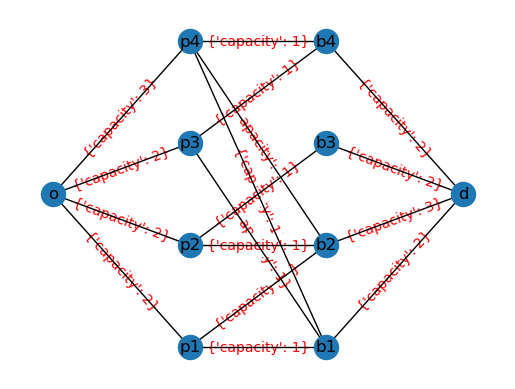

In [265]:
G['b1']['d']['capacity'] = 2
G['b2']['d']['capacity'] = 3
G['b3']['d']['capacity'] = 2
G['b4']['d']['capacity'] = 2
G['o']['p1']['capacity'] = 2
G['o']['p2']['capacity'] = 2
G['o']['p3']['capacity'] = 2
G['o']['p4']['capacity'] = 3

for e in original_edges:
    G[e[0]][e[1]]['capacity'] = 1

nx.draw_networkx_edge_labels(G,pos, font_color='red')
nx.draw(G, pos, with_labels = True)

#the new maximum capacity is 8, so all books but one have been succesfully assigned
nx.minimum_cut_value(G, "o", "d")

In [266]:
res = nx.maximum_flow(G, "o", "d")
res

(8,
 {'p1': {'b1': 0, 'b2': 1, 'o': 0},
  'b1': {'p1': 0, 'p3': 0, 'p4': 0, 'd': 2},
  'b2': {'p1': 0, 'p2': 0, 'p4': 0, 'd': 3},
  'p2': {'b2': 1, 'b3': 1, 'o': 0},
  'b3': {'p2': 0, 'd': 1},
  'p3': {'b4': 1, 'b1': 1, 'o': 0},
  'b4': {'p3': 0, 'p4': 0, 'd': 2},
  'p4': {'b1': 1, 'b2': 1, 'b4': 1, 'o': 0},
  'o': {'p1': 1, 'p2': 2, 'p3': 2, 'p4': 3},
  'd': {'b1': 0, 'b2': 0, 'b3': 0, 'b4': 0}})

### Exercise 2.c

Since the library can sell 1 copy of a book and buy a copy of another one, based on the results above we can see that $P_1$ is interested in $B_1$ but cannot take it.
Infact, there are only 2 copies but three person interested.

Instead, $B_3$ (which the library has 3 copies of), has only 1 person interested in it. 

Therefore, buy another one of $B_1$ and the library should sell 1 copy of $B_3$.

In [267]:
new_copies = [3, 3, 1, 2]

G['b1']['d']['capacity'] = 3
G['b2']['d']['capacity'] = 3
G['b3']['d']['capacity'] = 1
G['b4']['d']['capacity'] = 2

res = nx.maximum_flow(G, "o", "d")
res

(9,
 {'p1': {'b1': 1, 'b2': 1, 'o': 0},
  'b1': {'p1': 0, 'p3': 0, 'p4': 0, 'd': 3},
  'b2': {'p1': 0, 'p2': 0, 'p4': 0, 'd': 3},
  'p2': {'b2': 1, 'b3': 1, 'o': 0},
  'b3': {'p2': 0, 'd': 1},
  'p3': {'b4': 1, 'b1': 1, 'o': 0},
  'b4': {'p3': 0, 'p4': 0, 'd': 2},
  'p4': {'b1': 1, 'b2': 1, 'b4': 1, 'o': 0},
  'o': {'p1': 2, 'p2': 2, 'p3': 2, 'p4': 3},
  'd': {'b1': 0, 'b2': 0, 'b3': 0, 'b4': 0}})

## Exercise 3
Let's build the graph described in the exercise

In [1]:
import numpy as np
import scipy
import cvxpy as cp


C = scipy.io.loadmat('capacities.mat')["capacities"].reshape(28,)
B = scipy.io.loadmat('traffic.mat')["traffic"]
l = scipy.io.loadmat('traveltime.mat')["traveltime"].reshape(28,)

FileNotFoundError: [Errno 2] No such file or directory: 'capacities.mat'

In [269]:
C # 28
#B #The rows of B are associated with the nodes of the network and the columns (28x17)
#of B with the links.
#l #28

array([ 8741,  9864, 13350, 10926, 13707,  6960,  7422,  6678,  6297,
       11102,  8899,  8970,  9753,  9719,  9083,  7416, 13353, 11216,
       10947, 10019,  8732, 10763,  6677,  9403, 10355,  9067, 11990,
        8258], dtype=uint16)

### Exercise 3.a

In [270]:
import cvxpy as cp
import numpy as np
n_edges = B.shape[1]
print(n_edges)
tau = 1
nu = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]) * tau
f = cp.Variable(n_edges)
objective = cp.Minimize(l.T @ f)
constraints = [B @ f == nu, f >=0, f <= C]
prob = cp.Problem(objective, constraints)
result = prob.solve()
rounded_opt_f = [round(v) for v in f.value] #we are interested if it's taken or not (1/0).
print("Optimal f:", rounded_opt_f)

shortest_path = []

for i1 in range(B.shape[1]):
    
  for i2 in range(B.shape[0]):
    
    if B[i2][i1] == 1:
      v1 = i2+1
    
    if B[i2][i1] == -1:
      v2 = i2+1
    
  if rounded_opt_f[i1] == 1:    
    shortest_path.append((v1,v2))
    
    
print("shortest path:", shortest_path)


28
Optimal f: [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
shortest path: [(1, 2), (2, 3), (9, 13), (3, 9), (13, 17)]


### Exercise 3.b

In [271]:
n_edges = B.shape[1]
tau = 1
#in order to find the maximum capacity we iterate over a range of probable 
#maximum flow values
for x in range(20000, 30000):
    nu = np.array([x, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -x]) * tau
    f = cp.Variable(n_edges)
    I = np.ones(n_edges)
    objective = cp.Maximize(I@f)
    constraints = [B @ f == nu, f >=0, f <= C]
    prob = cp.Problem(objective, constraints)
    prob.solve()
    #if None values is returned the maximum capacity is reached in the previous cycle
    #therefore is enough to select the flow of the previous cycle subtracting one
    if f.value is None:
        x = x - 1
        print('max flow is:', x)
        break

max flow is: 22448


### Exercise 3.c

In [272]:
f = scipy.io.loadmat('flow.mat')["flow"].reshape(28,)
v = B@f
print(v[0])

16806


### Exercise 3.d

In [273]:
import cvxpy as cp
import numpy as np
n_edges = B.shape[1]
print(n_edges)
tau = v[0]
nu = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]) * tau
f = cp.Variable(n_edges)
I = np.ones(n_edges)
objective = cp.Minimize((l*C)@cp.inv_pos(I - f/C) - l.T@C)
constraints = [B @ f == nu, f >=0, f <= C]
prob = cp.Problem(objective, constraints)
prob.solve()
not_rounded_optimal_f = f.value
optimal_f = [round(v) for v in f.value]
print("Optimal f:", optimal_f)

28
Optimal f: [6642, 6059, 3132, 3132, 10164, 4638, 3006, 2543, 3132, 583, 0, 2927, 0, 3132, 5525, 2854, 4886, 2215, 464, 2338, 3318, 5656, 2373, 0, 6414, 5505, 4886, 4886]


### Exercise 3.e

In [274]:
import math as m
import cvxpy as cp
import numpy as np


C = scipy.io.loadmat('capacities.mat')["capacities"].reshape(28,)
B = scipy.io.loadmat('traffic.mat')["traffic"]
l = scipy.io.loadmat('traveltime.mat')["traveltime"].reshape(28,)

n_edges = B.shape[1]
print(n_edges)
tau = v[0]
nu = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1]) * tau
f = cp.Variable(n_edges)
I = np.ones(n_edges)

#((l*C).T @ (cp.log(C) @ cp.inv_pos(cp.log(C - f)))) se mettevo questo non funzionava: PERCHè
objective = cp.Minimize(((l*C).T @ (cp.log(C) - cp.log(C - f)))) 
constraints = [B @ f == nu, f >=0, f <= C -1]
prob = cp.Problem(objective, constraints)
prob.solve()
wardrop_f = [round(v) for v in f.value]
print("wardrop_flow:", wardrop_f)

28
wardrop_flow: [6716, 6716, 2367, 2367, 10090, 4645, 2804, 2284, 3418, 0, 177, 4171, 0, 2367, 5445, 2353, 4933, 1842, 697, 3036, 3050, 6087, 2587, 0, 6919, 4954, 4933, 4933]


In [275]:
#function that calculates the social optimum cost.
def tot_cost(f, l, c):    
  return np.sum(((l*c)/(np.ones(len(f))- f/c)) - l*c)


wardrop_cost = tot_cost(f = wardrop_f, l=l, c=C)
print("Wardrop cost:", wardrop_cost)

Wardrop cost: 26292.357750911066


### Exercise 3.e'

In [276]:
#omega is defined and added to the objective function.
omegas = ((l*(C) / (C - not_rounded_optimal_f)**2))* not_rounded_optimal_f
objective = cp.Minimize(((l*C).T @ (cp.log(C) - cp.log(C - f)))  + omegas.T@f ) #the result of the sum of the costs.
prob = cp.Problem(objective, constraints)
prob.solve()
wardrop_flow_with_tolls = [round(v) for v in f.value]

print(wardrop_flow_with_tolls)

[6643, 6059, 3132, 3132, 10163, 4638, 3006, 2542, 3131, 584, 0, 2927, 0, 3132, 5525, 2854, 4886, 2216, 464, 2337, 3318, 5656, 2373, 0, 6414, 5506, 4886, 4886]


In [277]:
wardrop_cost = tot_cost(f = wardrop_flow_with_tolls, l=l, c=C) #cost funxtion(tridente) is always t5he same
print("Wardrop cost:", wardrop_cost)

Wardrop cost: 25942.48725039416


In [278]:
#wardrop_flow and wardrop_flow_with_tolls are the same 
#(tolls push the flow to distrubute itself as in the the social optimum case)

### Exercise 3.f

In [279]:
#we have to recompute everything using the new cost function
f = cp.Variable(n_edges)
objective = cp.Minimize(((cp.inv_pos(np.ones(n_edges)-(f/C))).T@(l*C))-l.T@C -l.T@f)
constraints = [B @ f == nu, f >=0, f <= C]
prob = cp.Problem(objective, constraints)
result = prob.solve()
comparison_opt_flow = f.value
#rounding
rounded_opt_flow = [round(v) for v in comparison_opt_flow]
print("Optimal f:", rounded_opt_flow)
print("Optimal flow cost:", result)

Optimal f: [6653, 5775, 3420, 3420, 10153, 4643, 3106, 2662, 3009, 879, 0, 2355, 0, 3420, 5510, 3044, 4882, 2416, 444, 2008, 3487, 5495, 2204, 0, 6301, 5623, 4882, 4882]
Optimal flow cost: 15095.513524607872


In [280]:
#let's define the new omegas using the new social optimal flow
omegas_comparison = ((l*(C) / (C - comparison_opt_flow)**2)) * comparison_opt_flow
objective = cp.Minimize((C*l).T @ (cp.log(C) - cp.log(C-f)) -l.T@f +  omegas_comparison.T@f )
prob = cp.Problem(objective, constraints)
tolls_result = prob.solve()
flow_with_tolls = f.value
#rounding
rounded_tolls_flow = [round(v) for v in flow_with_tolls]
print("Wardrop f with tolls:", rounded_tolls_flow)

Wardrop f with tolls: [6653, 5775, 3419, 3419, 10153, 4642, 3105, 2662, 3009, 878, 0, 2356, 0, 3419, 5510, 3043, 4882, 2415, 444, 2009, 3487, 5496, 2204, 0, 6301, 5624, 4882, 4882]


In [281]:
def comparison_cost(f, l, c):
  return np.sum(((l*c)/(np.ones(len(f))- f/c)) - l*c - l*f)

  
tolls_cost = comparison_cost(f = flow_with_tolls, l=l, c=C)

print("Wardrop cost with tolls:", tolls_cost)

Wardrop cost with tolls: 15095.51325601912
